In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import pandas as pd
import seaborn as sns
import io #Used as buffer

In [2]:
nn_p = 5
nn_w = 5
nn_tw = 1
freq = 1
m='mof'

df = get_data(m)
df = df[(df['nnw']==str(nn_w))&(df['nntw']==str(nn_tw))&(df['nnp']==str(nn_p))|(df['isnn']==False)] 

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



# Plots

In [3]:
df_pivot = get_heatmap_data(m,df)[labels_order]
# df_pivot_rank = df_pivot.rank(axis=1)
df_pivot = df_pivot.reset_index()
df_pivot.experiment = df_pivot.experiment.str.slice(3)
df_pivot.set_index(['experiment','function','freq'], inplace=True)

In [4]:
df_pivot=df_pivot.query(f'freq>{freq}')
df_pivot_rank = df_pivot.rank(axis=1)

In [5]:
df_pivot_rank.style.background_gradient(cmap=plt.cm.Greens, axis=1)

invalid value encountered in less


In [6]:
summary = df_pivot_rank.groupby(['experiment', 'function']).mean()
summary.round(2).style.background_gradient(cmap=plt.cm.Greens, axis=1)

In [7]:
summary.round(2).style.highlight_min(axis=1)

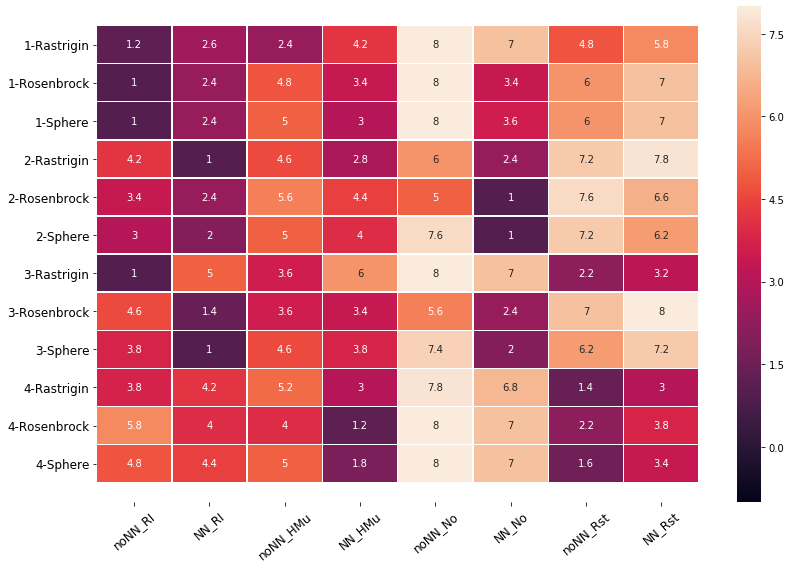

In [10]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(summary, annot=True, linewidths=.5, ax=ax, cmap=sns.cm.rocket, vmin=-1)
u,l = ax.get_ylim()
ax.set_ylim(u+0.5, l-0.5)
ax.set_ylabel('')
ax.set_xlabel('')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
    tick.label.set_rotation(40)
    
for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(12)
plt.tight_layout()
fig.savefig(PATH_RESULTS/'heatmap.eps', dpi=400, format='eps')